In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from scipy import sparse
from scipy.sparse.linalg import spsolve

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Tri_Mesh import Mesh

In [2]:
class Simplex_FEM():
    def __init__(self, mesh_nodes: dict, mesh_elems: dict, nu):
        self.nodes_dict = mesh_nodes
        self.elems_dict = mesh_elems

        self.n_nodes = len(mesh_nodes.keys())
        self.n_elems = len(mesh_elems.keys())

        # Degrees of freedom count
        self.n_dofs = 2 * self.n_nodes
        self.fixed_dofs = []
        self.all_dofs = np.arange(0, self.n_dofs)
        self.dofs_mapping = {}    # 6 DOFs for each element

        self.F = np.zeros(self.n_dofs)
        self.U = np.zeros(self.n_dofs)
        self.global_K = None

        # Poisson Ratio; Young modulus is considered = 1
        self.nu = nu

        self.D = np.array([
            [1 - nu, nu, 0],
            [nu, 1 - nu, 0],
            [0, 0, (1 - 2*nu)/2]
        ]) / ((1 + nu) * (1 - 2*nu))

    def map_DOFs(self):
        for elem_id in list(self.elems_dict.keys()):
            elem_nodes = self.elems_dict[elem_id]
            dofs = []
            for node in elem_nodes:
                dofs.append(2*(node - 1))
                dofs.append(2*(node - 1) + 1)
            self.dofs_mapping[elem_id] = dofs

    def elem_area(self, elem_id):
        elem_nodes = self.elems_dict[elem_id]
        
        x1 = self.nodes_dict[elem_nodes[0]][0]
        y1 = self.nodes_dict[elem_nodes[0]][1]
        
        x2 = self.nodes_dict[elem_nodes[1]][0]
        y2 = self.nodes_dict[elem_nodes[1]][1]
        
        x3 = self.nodes_dict[elem_nodes[2]][0]
        y3 = self.nodes_dict[elem_nodes[2]][1]

        area = ((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1)) / 2

        return area

    def local_K(self, elem_id):
        elem_nodes = self.elems_dict[elem_id]
        
        x1 = self.nodes_dict[elem_nodes[0]][0]
        y1 = self.nodes_dict[elem_nodes[0]][1]

        x2 = self.nodes_dict[elem_nodes[1]][0]
        y2 = self.nodes_dict[elem_nodes[1]][1]
        
        x3 = self.nodes_dict[elem_nodes[2]][0]
        y3 = self.nodes_dict[elem_nodes[2]][1]

        area = self.elem_area(elem_id)
        
        B = np.array([
            [y2 - y3, 0, y3 - y1, 0, y1 - y2, 0],
            [0, x3 - x2, 0, x1 - x3, 0, x2 - x1],
            [x3 - x2, y2 - y3, x1 - x3, y3 - y1, x2 - x1, y1 - y2]
        ]) / (2 * area)

        local_k = B.transpose().dot(self.D).dot(B) * area * 2
        return local_k

    def assemble_global_K(self, dens, penal, E_void, E0):
        global_iK = np.zeros(36 * self.n_elems)
        global_jK = np.zeros(36 * self.n_elems)
        global_aK = np.zeros(36 * self.n_elems)
        
        for ei, elem in enumerate(list(self.elems_dict.keys())):
            elem_density = dens[ei]
            
            young_modulus = E_void + pow(elem_density, penal) * (E0 - E_void)
            KE = self.local_K(elem) * young_modulus
            
            iK = np.kron(self.dofs_mapping[elem], np.ones(6))
            jK = np.reshape(np.kron(self.dofs_mapping[elem], np.reshape(np.ones(6), (6,1))), -1)
            aK = np.reshape(KE, -1)
            
            global_iK[36*ei : 36*(ei+1)] = iK
            global_jK[36*ei : 36*(ei+1)] = jK
            global_aK[36*ei : 36*(ei+1)] = aK
            
        self.global_K = sparse.coo_matrix((global_aK,(global_iK, global_jK)),shape = (self.n_dofs, self.n_dofs)).tocsr()

    def solve_U(self):
        free_dofs = np.setdiff1d(self.all_dofs, self.fixed_dofs)
        self.U[free_dofs] = spsolve(self.global_K[free_dofs, :][:, free_dofs], self.F[free_dofs])

        return self.U

    def fix_node(self, node_id, fix_X, fix_Y):
        dof_X = 2*(node_id - 1)
        dof_Y = 2*(node_id - 1) + 1
        
        if (fix_X == True):
            self.fixed_dofs.append(dof_X)
        if (fix_Y == True):
            self.fixed_dofs.append(dof_Y)

    def apply_load(self, node_id, load_X, load_Y):
        dof_X = 2*(node_id - 1)
        dof_Y = 2*(node_id - 1) + 1
        self.F[dof_X] = load_X
        self.F[dof_Y] = load_Y

In [3]:
class Config():
    def __init__(self):
        self.vol_frac = 0.0
        self.penalize = 0
        self.move = 0 
        self.dense_delta = 0.0
        self.max_iter = 0
        self.E_void = 0
        self.E0 = 0
        self.H = None
        self.sH = None
        self.fem_save_iters = None

In [4]:
def optimize(FEM_solver, config, verbose):
    iteration = 0
    
    x = np.ones(FEM_solver.n_elems) * config.vol_frac
    xPhys = x
    
    dense_c_norm = 1
    gamma = 1e-3

    while (dense_c_norm > config.dense_delta):
        iteration += 1
        
        if (verbose == True):
            print(f'Iteration {iteration}, c-norm = {dense_c_norm}')
        
        # Matrix assembly with individual densities
        FEM_solver.assemble_global_K(xPhys, config.penalize, config.E_void, config.E0)
        
        # Displacements
        u = FEM_solver.solve_U()
        
        # Compliance, Sensitivity, Filtering
        c = 0
        dc = np.array([])
        dv = np.array([])
        
        for i, elem_id in enumerate(list(FEM_solver.elems_dict.keys())):
            # Individual compliance
            ce = np.dot(np.dot(u[FEM_solver.dofs_mapping[elem_id]], FEM_solver.local_K(elem_id)), u[FEM_solver.dofs_mapping[elem_id]])
            young_modulus = config.E_void + pow(xPhys[i], config.penalize) * (config.E0 - config.E_void)

            c += young_modulus * ce
            curr_dc = -config.penalize * (config.E0 - config.E_void) * pow(xPhys[i], config.penalize - 1) * ce

            dc = np.append(dc, curr_dc)
            dv = np.append(dv, 1)
        
        # Filtering
        for i in range(dc.shape[0]):
            sum_1 = np.dot(dc * x, config.H[i])
            dc[i] = sum_1 / ((max(gamma, xPhys[i]) * config.sH[i]))

        # Optimality criteria
        lambda_1 = 0
        lambda_2 = 1e9

        x_new = np.zeros(x.shape)
        # Lambda binary search
        while ((lambda_2 - lambda_1) / (lambda_2 + lambda_1)) > 1e-3: 
            lambda_mid = (lambda_1 + lambda_2) / 2

            for i in range(x.shape[0]):
                B_e = np.sqrt(-dc[i] / (lambda_mid))
                if (x[i] * B_e <= max(0, x[i] - config.move)):
                    x_new[i] = max(0, x[i] - config.move)
                elif (x[i] * B_e >= min(1, x[i] + config.move)):
                    x_new[i] = min(1, x[i] + config.move)
                else:
                    x_new[i] = x[i] * B_e

            xPhys = x_new

            if (np.sum(xPhys) > config.vol_frac * FEM_solver.n_elems):
                lambda_1 = lambda_mid
            else:
                lambda_2 = lambda_mid
        
        if (iteration == config.max_iter):
            break
            
        dense_c_norm = np.max(np.abs(x_new - x))
        x = x_new
        
    return xPhys

In [5]:
# Reading mesh
mesh = Mesh()
mesh.read_mesh('TriOptiMesh_1')

mesh_nodes, mesh_elems = mesh.get_mesh()

Mesh from [TriOptiMesh_1] loaded.
----------------------------------------
Nodes: 		1265
Elements: 	2400


In [6]:
fem_solver = Simplex_FEM(mesh_nodes, mesh_elems, 0.3)
fem_solver.map_DOFs()

In [7]:
left_upper_id = mesh.left_upper()
right_upper_id = mesh.right_upper()
right_bottom_id = mesh.right_bottom()

In [8]:
fem_solver.apply_load(left_upper_id, 0, -1)
fem_solver.fix_node(right_upper_id, True, True)
fem_solver.fix_node(right_bottom_id, True, True)

In [9]:
config = Config()

In [10]:
config.vol_frac = 0.3
config.penalize = 3
config.dense_delta = 0.01
config.max_iter = 50
config.E0 = 1
config.E_void = 1e-9
config.filter_r = 0.05
config.move = 0.2

In [11]:
H, sH = mesh.calc_filter(config.filter_r)

config.H = H
config.sH = sH

In [12]:
densities = optimize(fem_solver, config, True)

Iteration 1, c-norm = 1
Iteration 2, c-norm = 0.2
Iteration 3, c-norm = 0.2
Iteration 4, c-norm = 0.20000000000000007
Iteration 5, c-norm = 0.20000000000000007
Iteration 6, c-norm = 0.20000000000000007
Iteration 7, c-norm = 0.20000000000000007
Iteration 8, c-norm = 0.20000000000000007
Iteration 9, c-norm = 0.17375643455716816
Iteration 10, c-norm = 0.13914958795072563
Iteration 11, c-norm = 0.13188081892756742
Iteration 12, c-norm = 0.08323058978297881
Iteration 13, c-norm = 0.08701765583303178
Iteration 14, c-norm = 0.053496530658399655
Iteration 15, c-norm = 0.04440424104315599
Iteration 16, c-norm = 0.030934115658594413
Iteration 17, c-norm = 0.02522401634751148
Iteration 18, c-norm = 0.02258405135090802
Iteration 19, c-norm = 0.020746665487258342
Iteration 20, c-norm = 0.01929764138947443
Iteration 21, c-norm = 0.018258816161472402
Iteration 22, c-norm = 0.017387491594233806
Iteration 23, c-norm = 0.015652776612733788
Iteration 24, c-norm = 0.015504627626270251
Iteration 25, c-norm

In [13]:
Xs = [mesh_nodes[key][0]-1 for key in list(mesh_nodes.keys())]
Ys = [mesh_nodes[key][1]-1 for key in list(mesh_nodes.keys())]
TriS = [list(map(lambda x: x-1, mesh_elems[key])) for key in list(mesh_elems.keys())]

In [14]:
triang = matplotlib.tri.Triangulation(Xs, Ys, TriS)

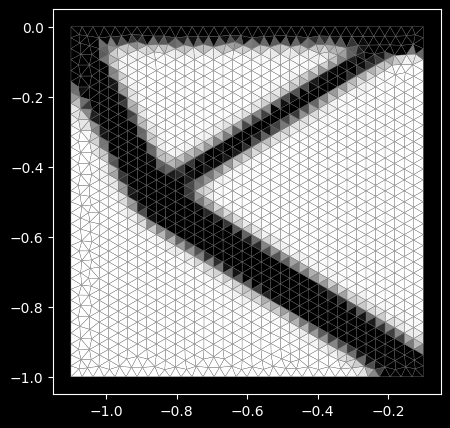

In [15]:
fig, ax = plt.subplots(figsize = (5,5))
ax.tripcolor(triang, densities, cmap = 'Greys', edgecolors = 'grey', shading = 'flat')